# Task 1: Data Collection and Preprocessing

## Objective
The goal of this task is to collect, clean, and prepare user reviews from the Google Play Store for three Ethiopian banking apps: Dashen Bank, Commercial Bank of Ethiopia (CBE), and Bank of Abyssinia (BOA). This data will be used for sentiment and thematic analysis in later stages.


## Import Required Libraries

In this section, we import the necessary libraries:

- `google_play_scraper`: to scrape reviews from the Google Play Store.
- `pandas`: for handling and manipulating tabular data.
- `datetime`: to format review timestamps.
- `csv`: included for potential CSV operations (optional if using pandas to save files).

In [1]:
from google_play_scraper import Sort, reviews
import pandas as pd
from datetime import datetime
import csv
import os

## Scrape Reviews for Each Bank App

This section defines the target banking apps with their respective Google Play Store App IDs. 
For each app, we scrape up to 500 of the most recent user reviews using the `google-play-scraper` package.

The following information is collected for each review:
- Review text (`content`)
- Star rating (`score`)
- Review date (`at`)
- App name (bank)
- Data source (`Google Play`)

All reviews are compiled into a single list and then converted into a Pandas DataFrame for further processing.

In [2]:
apps = {
    'Dashen Bank': 'com.dashen.dashensuperapp',
    'Commercial Bank of Ethiopia': 'com.combanketh.mobilebanking',
    'Bank of Abyssinia': 'com.boa.boaMobileBanking'
}

## Extract and Store Review Data

For each bank app in the `apps` dictionary, this loop:
- Requests the latest 500 reviews using the `reviews()` function.
- Extracts key details: review text, star rating, posting date, and source.
- Appends each review as a dictionary to the `all_reviews` list.

Once all reviews are collected, the list is converted into a Pandas DataFrame named `df_raw`, which provides a structured format for further cleaning and analysis.

In [3]:
all_reviews = []

for bank_name, app_id in apps.items():
    print(f"Scraping reviews for {bank_name}...")
    results, _ = reviews(
        app_id,
        lang='en',
        country='US',
        sort=Sort.NEWEST,
        count=500,
        filter_score_with=None
    )
    
    for entry in results:
        all_reviews.append({
            'review': entry['content'],
            'rating': entry['score'],
            'date': entry['at'].strftime('%Y-%m-%d'),
            'bank': bank_name,
            'source': 'Google Play'
        })

df_raw = pd.DataFrame(all_reviews)
df_raw.head()

Scraping reviews for Dashen Bank...
Scraping reviews for Commercial Bank of Ethiopia...
Scraping reviews for Bank of Abyssinia...


,review,rating,date,bank,source
0,good,5,2025-06-10,Dashen Bank,Google Play
1,very good .,5,2025-06-09,Dashen Bank,Google Play
2,this app is good for you guys,5,2025-06-09,Dashen Bank,Google Play
3,wow,5,2025-06-09,Dashen Bank,Google Play
4,kalid,5,2025-06-08,Dashen Bank,Google Play


## Preview Raw Data

Displaying the first few rows of the raw review dataset before cleaning.

## Clean the Review Data

To ensure data quality and accuracy, the following cleaning steps are applied:

1. **Remove Duplicates**  
   Duplicate entries are dropped based on a combination of `review`, `date`, and `bank` to avoid over-representing repeated feedback.

2. **Handle Missing Values**  
   Any rows with missing values in the key fields `review`, `rating`, or `date` are removed.

3. **Check Dataset Size**  
   The number of reviews before and after cleaning is printed to confirm how many were removed during preprocessing.


In [4]:
df_clean = df_raw.drop_duplicates(subset=['review', 'date', 'bank'])

df_clean = df_clean.dropna(subset=['review', 'rating', 'date'])

print(f"Original count: {len(df_raw)}")
print(f"Cleaned count: {len(df_clean)}")

Original count: 1454
Cleaned count: 1432


## Save the Cleaned Dataset

After cleaning, the final dataset is saved to a CSV file for later use in sentiment and thematic analysis.

- The filename includes a timestamp to ensure uniqueness and version tracking.
- The file is saved without the index column.
- A confirmation message is printed showing the file name and successful save.

In [5]:
filename = f"cleaned_reviews.csv"
df_clean.to_csv(f"../data/{filename}", index=False)
print(f"✅ Saved cleaned dataset as: data/{filename}")

✅ Saved cleaned dataset as: data/cleaned_reviews.csv


## ✅ Task 1 Summary

- Scraped 500 reviews for each bank (1,500 total).
- Cleaned the dataset by removing duplicates and missing entries.
- Saved the cleaned data to a timestamped CSV file in the `data/` directory.
- Ready to proceed with sentiment and thematic analysis in Task 2.

# Task 2: Sentiment and Thematic Analysis

## Objective

In this task, we begin analyzing customer feedback collected in Task 1 to understand user satisfaction and pain points. We will:

- Perform sentiment analysis using the VADER model.
- Classify reviews into Positive, Negative, or Neutral.
- Summarize sentiment trends for each bank.

These results will support deeper thematic analysis in the next phase.

## Step 1: Sentiment Analysis Setup

We use the VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tool. 
It is a lexicon and rule-based sentiment analysis model well-suited for social media and short texts like user reviews.

In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

## Load Cleaned Review Data

We load the preprocessed dataset created in Task 1. This dataset contains user reviews, star ratings, dates, and associated bank information for three Ethiopian banking apps.

In [7]:
df = pd.read_csv("../data/cleaned_reviews.csv")  # <-- replace with your filename
df.head()

,review,rating,date,bank,source
0,good,5,2025-06-10,Dashen Bank,Google Play
1,very good .,5,2025-06-09,Dashen Bank,Google Play
2,this app is good for you guys,5,2025-06-09,Dashen Bank,Google Play
3,wow,5,2025-06-09,Dashen Bank,Google Play
4,kalid,5,2025-06-08,Dashen Bank,Google Play


## Define Sentiment Classification Function

Using the VADER sentiment analyzer, we define a helper function to classify reviews into:
- **Positive** (compound score ≥ 0.05)
- **Negative** (compound score ≤ -0.05)
- **Neutral** (otherwise)

The compound score represents overall sentiment intensity.

In [8]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_label(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

## Apply Sentiment Analysis to Reviews

We apply our sentiment classification function to each review and store the result in a new column called `sentiment`. A preview of the review text and its corresponding sentiment label is shown below.

In [9]:
df['sentiment'] = df['review'].apply(get_sentiment_label)
df[['review', 'sentiment']].head()

,review,sentiment
0,good,positive
1,very good .,positive
2,this app is good for you guys,positive
3,wow,positive
4,kalid,neutral


In [10]:
sentiment_summary = df.groupby(['bank', 'sentiment']).size().unstack().fillna(0)
sentiment_summary

sentiment,negative,neutral,positive
bank,,,
Bank of Abyssinia,118,162,219
Commercial Bank of Ethiopia,36,115,329
Dashen Bank,26,91,336


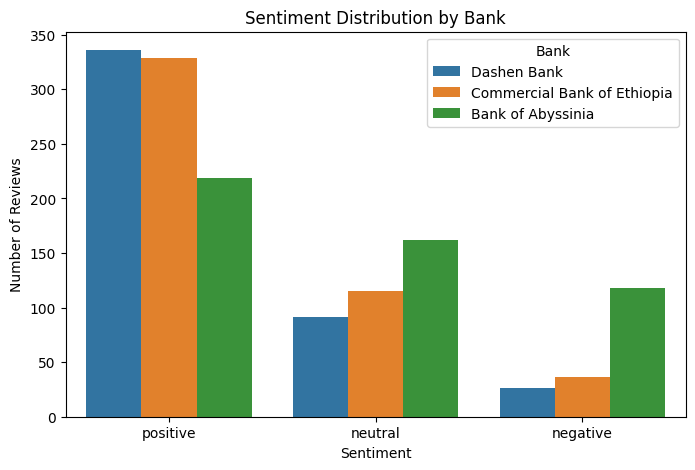

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment', hue='bank')
plt.title("Sentiment Distribution by Bank")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.legend(title="Bank")
plt.show()

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bereket\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Apply cleaning function to the 'review' column
df['cleaned_review'] = df['review'].astype(str).apply(clean_text)

# Show sample of original vs cleaned
df[['review', 'cleaned_review']].head()

,review,cleaned_review
0,good,good
1,very good .,good
2,this app is good for you guys,app good guys
3,wow,wow
4,kalid,kalid


In [14]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, max_features=50)
X = vectorizer.fit_transform(df['cleaned_review'])

# Get keywords and their TF-IDF scores
tfidf_keywords = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf_keywords)
tfidf_df.head()

,always,amazing,app,application,apps,bank,banking,best,better,boa,...,transaction,transactions,update,use,user,using,work,working,worst,wow
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.587296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
themes = {
    'Account Access Issues': ['login', 'password', 'otp', 'authentication'],
    'Transaction Problems': ['transfer', 'failed', 'payment', 'error'],
    'Performance & Speed': ['slow', 'load', 'crash', 'freeze'],
    'User Interface': ['design', 'easy', 'navigation', 'interface'],
    'Features & Requests': ['update', 'fingerprint', 'option', 'feature']
}

In [16]:
def assign_theme(text):
    matched_themes = []
    for theme, keywords in themes.items():
        if any(word in text for word in keywords):
            matched_themes.append(theme)
    return ', '.join(matched_themes) if matched_themes else 'Other'

df['themes'] = df['cleaned_review'].apply(assign_theme)
df[['review', 'themes']].head()

,review,themes
0,good,Other
1,very good .,Other
2,this app is good for you guys,Other
3,wow,Other
4,kalid,Other


In [17]:
theme_summary = df.groupby(['bank', 'themes']).size().unstack(fill_value=0)
theme_summary

themes,Account Access Issues,"Account Access Issues, Features & Requests","Account Access Issues, Performance & Speed","Account Access Issues, Transaction Problems","Account Access Issues, Transaction Problems, Performance & Speed","Account Access Issues, Transaction Problems, Performance & Speed, Features & Requests","Account Access Issues, Transaction Problems, User Interface","Account Access Issues, User Interface, Features & Requests",Features & Requests,Other,...,"Performance & Speed, User Interface, Features & Requests",Transaction Problems,"Transaction Problems, Features & Requests","Transaction Problems, Performance & Speed","Transaction Problems, Performance & Speed, Features & Requests","Transaction Problems, Performance & Speed, User Interface, Features & Requests","Transaction Problems, User Interface","Transaction Problems, User Interface, Features & Requests",User Interface,"User Interface, Features & Requests"
bank,,,,,,,,,,,,,,,,,,,,,
Bank of Abyssinia,4,2,2,2,1,1,0,0,22,401,...,0,12,1,4,1,0,0,0,6,0
Commercial Bank of Ethiopia,0,0,0,0,0,0,0,0,18,411,...,0,15,3,0,0,0,0,0,20,0
Dashen Bank,4,0,1,2,0,0,1,1,31,328,...,1,14,3,0,0,1,3,7,32,10


In [18]:
df.to_csv("../data/reviews_with_sentiment_and_themes.csv", index=False)
print("✅ Dataset saved with sentiment and themes included.")

✅ Dataset saved with sentiment and themes included.


## Task 2 Summary: Sentiment and Thematic Analysis

- We used VADER to classify user reviews into **positive**, **neutral**, or **negative**.
- Reviews were cleaned and processed using standard NLP methods (lowercasing, stopword removal, etc.).
- TF-IDF was applied to extract top keywords across all reviews.
- Keywords were grouped into five main themes:
  - Account Access Issues
  - Transaction Problems
  - Performance & Speed
  - User Interface
  - Feature Requests
- Each review was tagged with matching themes based on content.
- A summary table shows the distribution of themes across each bank.

This completes Task 2. The dataset is now ready for visualization and storage.

## Task 3: Store Cleaned Data in Oracle
### Step 1: Connect to Oracle XE

We begin Task 3 by setting up the connection between Python and our Oracle XE database. We initialize the Oracle Instant Client using `cx_Oracle.init_oracle_client()` and establish a connection using our username, password, and the database's service name (`XEPDB1`). This step is essential to allow data transfer from our script into Oracle.

### Step 2: Verify Connection

We confirm that the connection to Oracle XE has been successfully established by printing the database version. This helps ensure we are connected and ready to execute further SQL commands.

In [19]:
import cx_Oracle

# Re-initialize Oracle client path
cx_Oracle.init_oracle_client(lib_dir=r"C:\Users\Bereket\Downloads\Compressed\New folder\instantclient_23_8")

# Reconnect
dsn = cx_Oracle.makedsn("localhost", 1521, service_name="XEPDB1")
conn = cx_Oracle.connect(user="system", password="1993", dsn=dsn)

print("✅ Reconnected to Oracle")


✅ Reconnected to Oracle


### Step 3: Create the REVIEWS Table

We define and create the `REVIEWS` table in our Oracle database. The table stores one row per review and includes the following fields:
- `REVIEW_TEXT`: the actual user review
- `RATING`: numeric rating from 1 to 5
- `REVIEW_DATE`: the date the review was posted
- `BANK_NAME`: the name of the bank the review is about
- `SENTIMENT`: the predicted sentiment label (positive, neutral, negative)
- `THEMES`: identified topic(s) based on keyword matching

This schema mirrors our cleaned data and prepares Oracle to store the final dataset.

In [20]:
cursor = conn.cursor()

cursor.execute("""
    CREATE TABLE REVIEWS (
        ID              NUMBER GENERATED ALWAYS AS IDENTITY PRIMARY KEY,
        REVIEW_TEXT     CLOB,
        RATING          NUMBER,
        REVIEW_DATE     DATE,
        BANK_NAME       VARCHAR2(100),
        SENTIMENT       VARCHAR2(20),
        SENTIMENT_SCORE NUMBER,
        THEMES          VARCHAR2(200)
    )
""")

conn.commit()
cursor.close()
print("✅ Table created successfully.")


✅ Table created successfully.


### Step 4: Load Cleaned Review Data

We load our cleaned dataset from Task 2 into a pandas DataFrame. This dataset includes sentiment labels and themes and will be inserted into the REVIEWS table created in the previous step.

In [21]:
df = pd.read_csv("../data/reviews_with_sentiment_and_themes.csv")
df.head()

,review,rating,date,bank,source,sentiment,cleaned_review,themes
0,good,5,2025-06-10,Dashen Bank,Google Play,positive,good,Other
1,very good .,5,2025-06-09,Dashen Bank,Google Play,positive,good,Other
2,this app is good for you guys,5,2025-06-09,Dashen Bank,Google Play,positive,app good guys,Other
3,wow,5,2025-06-09,Dashen Bank,Google Play,positive,wow,Other
4,kalid,5,2025-06-08,Dashen Bank,Google Play,neutral,kalid,Other


### Step 5: Insert Data into REVIEWS Table

We insert the cleaned and labeled data from the DataFrame into our Oracle `REVIEWS` table. The insertion is done using `executemany()` for efficiency, and each row includes review text, rating, date, bank name, sentiment label, and themes.

In [24]:
cursor = conn.cursor()

insert_sql = """
    INSERT INTO REVIEWS (REVIEW_TEXT, RATING, REVIEW_DATE, BANK_NAME, SENTIMENT, THEMES)
    VALUES (:1, :2, TO_DATE(:3, 'YYYY-MM-DD'), :4, :5, :6)
"""

data = [
    (
        row["review"],
        row["rating"],
        row["date"],
        row["bank"],
        row["sentiment"],
        row["themes"]
    )
    for _, row in df.iterrows()
]

cursor.executemany(insert_sql, data)
conn.commit()
cursor.close()
print(f"✅ Inserted {len(data)} rows into REVIEWS table.")


✅ Inserted 1432 rows into REVIEWS table.


### Final Output: Confirm Number of Inserted Rows

We print a confirmation showing how many rows were successfully inserted into the REVIEWS table. This confirms the successful completion of Task 3.

### Step 1: Load Data from Oracle Database

We begin Task 4 by querying the `REVIEWS` table and loading the results into a pandas DataFrame. This makes it easier to perform summary statistics and visualizations using Python tools.

In [25]:
query = """
SELECT 
    REVIEW_TEXT, 
    RATING, 
    REVIEW_DATE, 
    BANK_NAME, 
    SENTIMENT, 
    THEMES 
FROM REVIEWS
"""

df = pd.read_sql(query, con=conn)

# Convert date to datetime
df['REVIEW_DATE'] = pd.to_datetime(df['REVIEW_DATE'])

df.head()

C:\Users\Bereket\AppData\Local\Temp\ipykernel_10532\2976868716.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, con=conn)


,REVIEW_TEXT,RATING,REVIEW_DATE,BANK_NAME,SENTIMENT,THEMES
0,good,5,2025-06-10,Dashen Bank,positive,Other
1,very good .,5,2025-06-09,Dashen Bank,positive,Other
2,this app is good for you guys,5,2025-06-09,Dashen Bank,positive,Other
3,wow,5,2025-06-09,Dashen Bank,positive,Other
4,kalid,5,2025-06-08,Dashen Bank,neutral,Other


### Step 2: Sentiment Distribution

We visualize the number of reviews classified as Positive, Neutral, or Negative. This helps us understand the general tone of customer feedback across all banks.

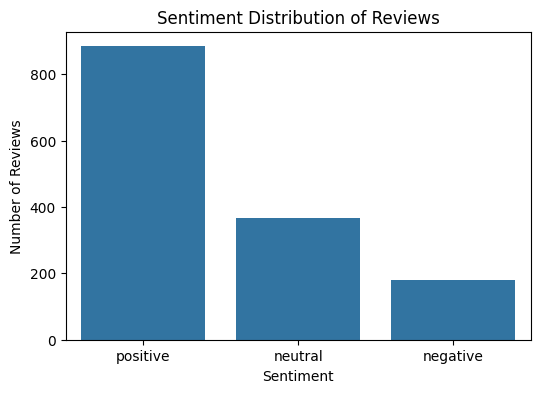

In [26]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='SENTIMENT', order=df['SENTIMENT'].value_counts().index)
plt.title("Sentiment Distribution of Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

### Summary Statistics of Ratings

We begin the analysis by computing basic statistics for customer ratings. This provides an overview of the average satisfaction level across all reviews.


In [27]:
df['RATING'].describe()

count    1432.000000
mean        3.874302
std         1.653697
min         1.000000
25%         3.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: RATING, dtype: float64

### Sentiment Breakdown by Bank

Here, we group the reviews by bank and sentiment to see how each bank is perceived. The stacked bar chart shows which banks receive more positive, neutral, or negative reviews.

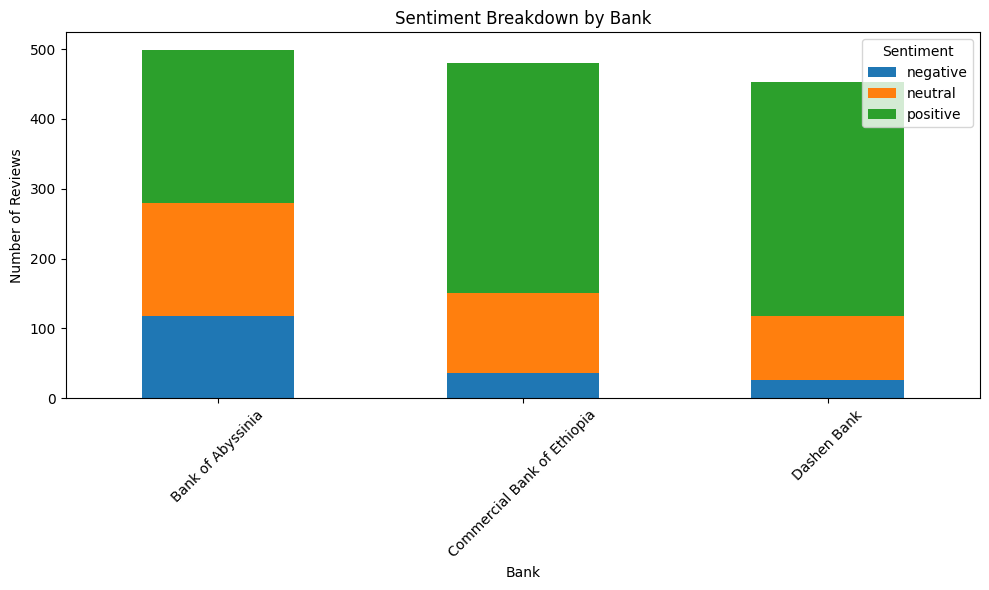

In [28]:
sentiment_by_bank = df.groupby(['BANK_NAME', 'SENTIMENT']).size().unstack().fillna(0)
sentiment_by_bank.plot(kind='bar', figsize=(10, 6), stacked=True)
plt.title("Sentiment Breakdown by Bank")
plt.xlabel("Bank")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

### Monthly Review Trends

This line chart displays the number of reviews received by each bank over time. It helps identify spikes in customer engagement or issues that may have triggered more reviews.


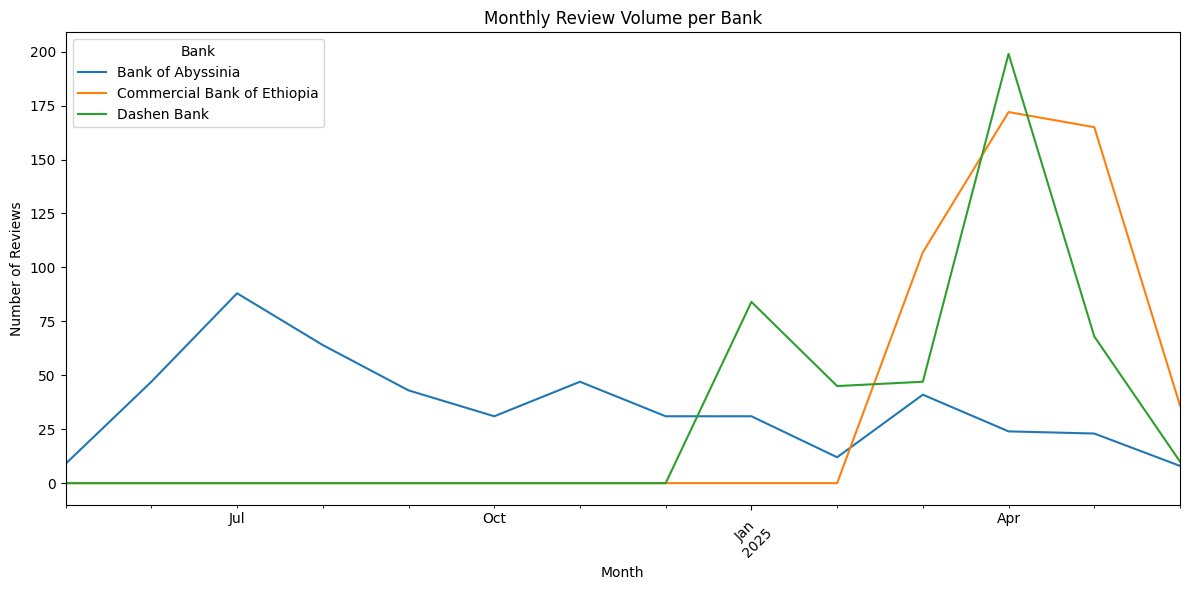

In [29]:
df['Month'] = df['REVIEW_DATE'].dt.to_period('M')
monthly_trend = df.groupby(['Month', 'BANK_NAME']).size().unstack(fill_value=0)

monthly_trend.plot(figsize=(12, 6))
plt.title("Monthly Review Volume per Bank")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.legend(title="Bank")
plt.tight_layout()
plt.show()

### Top Themes from Customer Reviews

We extract and count the most frequently mentioned themes in the reviews. This gives us insight into which features, services, or issues matter most to customers.


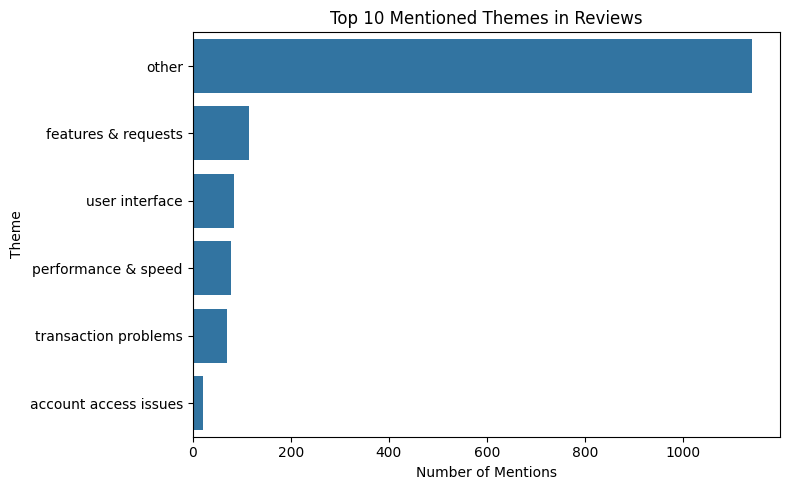

In [30]:
from collections import Counter

themes = df['THEMES'].dropna().str.lower().str.split(',')
theme_list = [theme.strip() for sublist in themes for theme in sublist]
theme_counts = Counter(theme_list)

top_themes = pd.DataFrame(theme_counts.most_common(10), columns=['Theme', 'Count'])

plt.figure(figsize=(8, 5))
sns.barplot(data=top_themes, x='Count', y='Theme')
plt.title("Top 10 Mentioned Themes in Reviews")
plt.xlabel("Number of Mentions")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()

### Average Customer Rating per Bank

We calculate and visualize the average rating received by each bank. This helps compare overall customer satisfaction levels between banks.


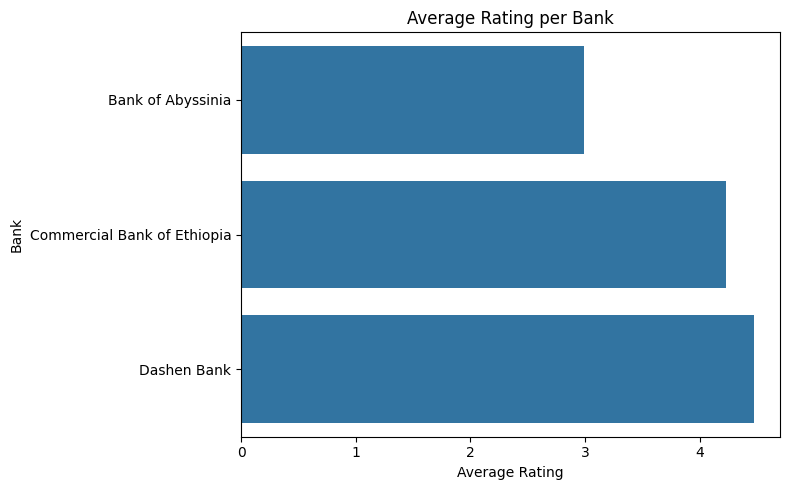

In [31]:
avg_rating = df.groupby('BANK_NAME')['RATING'].mean().sort_values()

plt.figure(figsize=(8, 5))
sns.barplot(x=avg_rating.values, y=avg_rating.index)
plt.title("Average Rating per Bank")
plt.xlabel("Average Rating")
plt.ylabel("Bank")
plt.tight_layout()
plt.show()